In [2]:
from __future__ import print_function

import argparse

import numpy as np
import torch
import torch.utils.data

import sys
sys.path.append('../model')
from model import RecurrentNetTimeVariable

import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
use_cuda = False
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = RecurrentNetTimeVariable(n_in=200, n_hid=500, n_out=1,
                                     use_cuda=use_cuda).to(device)
# model.load_state_dict(torch.load('../trained_models/which_pattern_02_50_08_450_epoch_501.pth', map_location='cpu'))



cpu


In [66]:
when_slow_signal = []
def lsm_signals(n_episodes=100, n_in=100, stim_dur=15,
                sig1_stim_dur=20, resp_dur=10, each_episodes=10, kappa=5.0, spon_rate=0.08, n_stim=3):
    phi = np.linspace(0, np.pi, n_in)
    n_loc = 1
    nneuron = n_in * n_loc
    total_dur = n_stim * (stim_dur + resp_dur)
    G = (1.0 / stim_dur) * np.random.choice([1.0], 1)
    G = np.repeat(G, n_in, axis=0).T
    G = np.tile(G, (stim_dur, 1))

    # signal2
    Stims = []
    Stims_ = []
    Ls = []
    Rs = []
    for episode in range(n_episodes):
        episode_stim = []
        for i in range(n_stim):
            S = np.pi * np.random.rand(1)
            S_ = S.copy()
            S = np.repeat(S, n_in, axis=0).T
            S = np.tile(S, (stim_dur, 1))
            Stims.append(S)
            episode_stim.append(S_)

            # Noisy responses
            L = G * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (stim_dur, n_loc)))) - 1.0))  # stim

            Ls.append(L)
            R = np.random.poisson(L)
            Rs.append(R)
        Stims_.append(episode_stim)
        Lr = (spon_rate / resp_dur) * np.ones((resp_dur * n_stim, nneuron))  # resp
        Rr = np.random.poisson(Lr)

        Rs.append(Rr)

    signal2 = np.concatenate(tuple(Rs), axis=0)

    G1 = (3.0 / sig1_stim_dur) * np.random.choice([1.0], 1)
    G1 = np.repeat(G1, n_in, axis=0).T
    G1 = np.tile(G1, (sig1_stim_dur, 1))
    # signal1 & target
    a = np.random.poisson(0.8, n_episodes)
    Rs1 = []
    accum_signal = np.pi * np.random.rand(1)
    target_list = []

    for episode in range(n_episodes):
        target_list.append(np.zeros(stim_dur * n_stim))
        if a[episode] == 2 or episode % each_episodes == 0:
            # print(episode)
            when_slow_signal.append(episode)
            accum_signal = np.pi * np.random.rand(1)
            S = np.repeat(accum_signal, n_in, axis=0).T
            S = np.tile(S, (sig1_stim_dur, 1))

            L = G1 * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (sig1_stim_dur, n_loc)))) - 1.0))  # stim
            R = np.random.poisson(L)
            Rs1.append(R)
        else:
            Lr = (spon_rate / resp_dur) * np.ones((sig1_stim_dur, nneuron))  # resp
            R = np.random.poisson(Lr)
            Rs1.append(R)
        L_spont = (spon_rate / resp_dur) * np.ones((total_dur - sig1_stim_dur, nneuron))  # resp
        R = np.random.poisson(L_spont)
        Rs1.append(R)

        for i in range(n_stim):
            target = np.repeat(Stims_[episode][i]+accum_signal, resp_dur, axis=0)
            # target = np.repeat(Stims_[episode][i], resp_dur, axis=0)
            target_list.append(target)

    signal1 = np.concatenate(tuple(Rs1), axis=0)

    target = np.concatenate(tuple(target_list), axis=0)
    target = np.expand_dims(target, 1)

    signal = np.concatenate((signal1, signal2), axis=1)
    return signal, target

In [67]:
signals = []
targets = []
for i in range(1):
    signal, target = lsm_signals(n_episodes=20,
                                                  stim_dur=7,
                                                  sig1_stim_dur=7,
                                                  resp_dur=5,
                                                  each_episodes=30,
                                                  spon_rate=0.01)
    signals.append(signal)
    targets.append(target)
    

signals = np.array(signals)
targets = np.array(targets)

signals = torch.from_numpy(signals)
targets = torch.from_numpy(targets)

hidden = torch.zeros(1, 500, requires_grad=False)
hidden = hidden.to(device)

signals = signals.float()
targets = targets.float()

signals, targets = signals.to(device), targets.to(device)

hidden_list, output, hidden = model(signals, hidden)


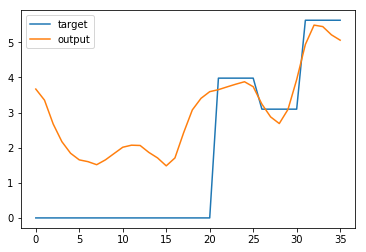

In [68]:
plt.plot(targets[0].data.numpy().T[0][72:108], label='target')
plt.plot(output[0].data.numpy().T[0][72:108], label='output')
plt.legend()

In [1]:
import seaborn as sns
sns.heatmap(hidden_list.data.numpy()[0].T, cmap='OrRd')

NameError: name 'hidden_list' is not defined

Text(33,0.5,'neuron index')

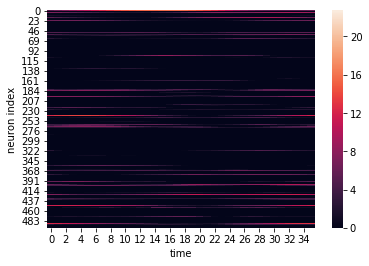

In [70]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:500, 72:108])
plt.xlabel('time')
plt.ylabel('neuron index')

In [71]:
from sklearn.decomposition import PCA
X = hidden_list.data.numpy()[0]
pca = PCA(n_components=3)
pca.fit(X)

Xd = pca.transform(X)

[0, 3, 11, 18]


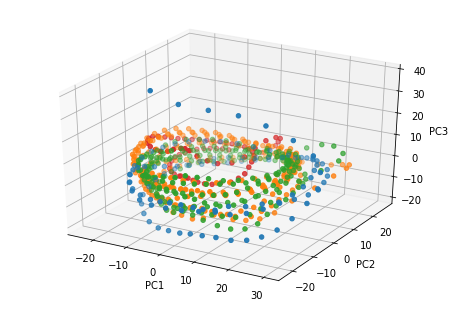

In [72]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap("tab10")
fig = plt.figure()
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

print(when_slow_signal)

color = 0
for i in range(len(when_slow_signal)-1):
    ax.scatter(Xd.T[0][36*when_slow_signal[i]:36*when_slow_signal[i+1]], Xd.T[1][36*when_slow_signal[i]:36*when_slow_signal[i+1]], Xd.T[2][36*when_slow_signal[i]:36*when_slow_signal[i+1]],color=cmap(i),)
    color += 1
    
ax.scatter(Xd.T[0][36*when_slow_signal[-1]:], Xd.T[1][36*when_slow_signal[-1]:], Xd.T[2][36*when_slow_signal[-1]:],color=cmap(color),)


In [30]:
import torch.nn.functional as F
const_one = torch.Tensor([1])
alpha = model.alpha(const_one)

In [31]:
thresholded_index = [i for i in range(500) if alpha[i] > 0.15]

In [32]:
print(only_fast_dynamics.shape)

(500, 720)


In [33]:
only_fast_dynamics = np.array([hidden_list.data.numpy()[0].T[i] for i in thresholded_index])

In [34]:
from sklearn.decomposition import PCA
X = only_fast_dynamics.T
pca = PCA(n_components=3)
pca.fit(X)

Xd = pca.transform(X)

[0, 4, 14]


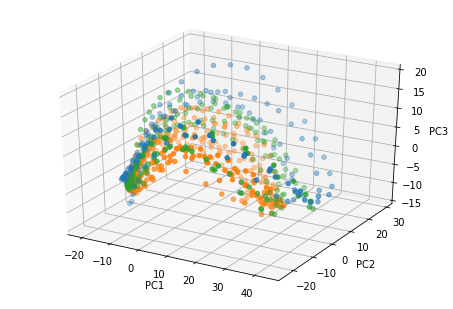

In [35]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap("tab10")
fig = plt.figure()
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

print(when_slow_signal)

color = 0
for i in range(len(when_slow_signal)-1):
    ax.scatter(Xd.T[0][36*when_slow_signal[i]:36*when_slow_signal[i+1]], Xd.T[1][36*when_slow_signal[i]:36*when_slow_signal[i+1]], Xd.T[2][36*when_slow_signal[i]:36*when_slow_signal[i+1]],color=cmap(i),)
    color += 1
    
ax.scatter(Xd.T[0][36*when_slow_signal[-1]:], Xd.T[1][36*when_slow_signal[-1]:], Xd.T[2][36*when_slow_signal[-1]:],color=cmap(color),)


In [36]:
const_one = torch.Tensor([1])
alpha = model.alpha(const_one)
alpha 

tensor([0.3831, 0.3329, 0.2920, 0.2980, 0.3788, 0.3140, 0.2976, 0.3112, 0.2865,
        0.2781, 0.3827, 0.3024, 0.2984, 0.2726, 0.2734, 0.2879, 0.2527, 0.2871,
        0.3046, 0.2386, 0.3563, 0.2886, 0.2365, 0.3083, 0.3257, 0.2451, 0.2960,
        0.0249, 0.2617, 0.3702, 0.3004, 0.2948, 0.3031, 0.2892, 0.3013, 0.2994,
        0.2860, 0.2331, 0.2871, 0.2845, 0.2956, 0.3014, 0.2756, 0.3561, 0.2949,
        0.2938, 0.2693, 0.2887, 0.2881, 0.2836, 0.2918, 0.1718, 0.2451, 0.3873,
        0.2831, 0.2955, 0.2580, 0.3600, 0.0944, 0.2637, 0.3791, 0.3328, 0.3402,
        0.2859, 0.2021, 0.2887, 0.3351, 0.2962, 0.2076, 0.2981, 0.3036, 0.2175,
        0.2500, 0.3791, 0.4018, 0.0361, 0.2911, 0.2854, 0.3775, 0.2436, 0.2071,
        0.3089, 0.2104, 0.1558, 0.2710, 0.2901, 0.2224, 0.2789, 0.1159, 0.3018,
        0.2913, 0.3293, 0.3858, 0.2679, 0.3044, 0.3668, 0.2874, 0.3002, 0.3444,
        0.2617, 0.2607, 0.2954, 0.3201, 0.2787, 0.2955, 0.2539, 0.2884, 0.1457,
        0.3110, 0.2647, 0.3078, 0.2723, 

In [37]:
alpha.sort()

(tensor([0.0227, 0.0249, 0.0361, 0.0446, 0.0944, 0.0973, 0.0989, 0.1159, 0.1338,
         0.1405, 0.1457, 0.1484, 0.1558, 0.1610, 0.1640, 0.1688, 0.1718, 0.1727,
         0.1732, 0.1739, 0.1752, 0.1767, 0.1801, 0.1869, 0.1907, 0.1923, 0.1928,
         0.1964, 0.1977, 0.2011, 0.2020, 0.2021, 0.2042, 0.2069, 0.2071, 0.2071,
         0.2076, 0.2086, 0.2086, 0.2086, 0.2104, 0.2115, 0.2148, 0.2168, 0.2173,
         0.2175, 0.2177, 0.2218, 0.2220, 0.2224, 0.2226, 0.2244, 0.2275, 0.2279,
         0.2280, 0.2304, 0.2331, 0.2344, 0.2353, 0.2365, 0.2379, 0.2386, 0.2390,
         0.2418, 0.2426, 0.2435, 0.2436, 0.2440, 0.2451, 0.2451, 0.2455, 0.2458,
         0.2473, 0.2480, 0.2491, 0.2492, 0.2500, 0.2500, 0.2506, 0.2509, 0.2514,
         0.2524, 0.2527, 0.2529, 0.2535, 0.2539, 0.2542, 0.2551, 0.2554, 0.2566,
         0.2568, 0.2578, 0.2579, 0.2580, 0.2582, 0.2582, 0.2584, 0.2586, 0.2597,
         0.2600, 0.2607, 0.2610, 0.2617, 0.2617, 0.2633, 0.2634, 0.2637, 0.2637,
         0.2639, 0.2647, 0.2